<a href="https://colab.research.google.com/github/ercentamore/erc_visual-inspection/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project**

### **Import and setup**

In [43]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [38]:
#import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms
from torch.nn import functional as F
from zipfile import ZipFile
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from urllib.parse import urlparse
import requests
import torch.optim as optim
from torch.amp import autocast, GradScaler
from torch.nn import Parameter as P
import gc
! pip install sync_batchnorm
from sync_batchnorm import SynchronizedBatchNorm2d as SyncBatchNorm2d
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
! pip install pytorch-pretrained-biggan
import BigGAN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
device = 'cuda'
gc.collect()
torch.cuda.empty_cache()
torch.cuda.is_available()
CUDA_LAUNCH_BLOCKING=1

### **Helper Functions - run first**


In [12]:
def load_partial_weights(model, checkpoint_path, device = device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model_dict = model.state_dict()

    # Filter out weights that don't match size or key
    pretrained_dict = {
        k: v for k, v in checkpoint.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }

    # Report what was loaded
    print(f"Loaded {len(pretrained_dict)} / {len(model_dict)} parameters from checkpoint.")

    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    to_freeze = list(pretrained_dict.keys())
    copy = to_freeze
    for item in copy:
        if '.u' in item or '.sv' in item:
            to_freeze.remove(item)
    return to_freeze

In [13]:
def download_images_from_dataframe(df, url_column, output_folder, filename_prefix="image"):
    """
    Download images from URLs in a dataframe and save them to a folder.

    Parameters:
    - df: pandas DataFrame containing the image URLs
    - url_column: column name in the dataframe that contains the image URLs
    - output_folder: folder where images will be saved
    - filename_prefix: prefix for the filenames (default: "image")

    Returns:
    - A list of successfully downloaded file paths
    """
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    downloaded_files = []

    # Loop through each URL in the dataframe
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Downloading images"):
        url = row[url_column]

        try:
            # Generate filename from URL or use index
            if isinstance(url, str) and url.strip():
                # Try to extract filename from URL
                parsed_url = urlparse(url)
                path_parts = parsed_url.path.split('/')
                if path_parts and path_parts[-1]:
                    original_filename = path_parts[-1]
                    # Remove query parameters if present
                    original_filename = original_filename.split('?')[0]
                    # Ensure .jpg extension
                    basename, ext = os.path.splitext(original_filename)
                    if not ext or ext.lower() != '.jpg':
                        filename = f"{basename}.jpg"
                    else:
                        filename = original_filename
                else:
                    filename = f"{filename_prefix}_{idx}.jpg"
            else:
                filename = f"{filename_prefix}_{idx}.jpg"

            output_path = os.path.join(output_folder, filename)

            # Download the image
            response = requests.get(url, stream=True, timeout=10)
            response.raise_for_status()  # Raise an exception for HTTP errors

            # Save the image
            with open(output_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)

            downloaded_files.append(output_path)

        except Exception as e:
            print(f"Error downloading {url}: {e}")

    print(f"Downloaded {len(downloaded_files)} images to {output_folder}")
    return downloaded_files

In [14]:
def display_tensor_image(image_tensor):
    """
    Display an image tensor using matplotlib.

    Args:
        image_tensor: A PyTorch tensor of shape [C, H, W] in the range [0, 1]
        title: Optional title for the displayed image
    """
    if image_tensor.is_cuda:
        image_tensor = image_tensor.cpu()

    if image_tensor.shape[0] == 3:

        img_np = image_tensor.permute(1, 2, 0).numpy()
    elif image_tensor.shape[0] == 1:
        img_np = image_tensor.squeeze(0).numpy()
    else:
        raise ValueError(f"Unexpected tensor shape: {image_tensor.shape}")

    plt.figure(figsize=(8, 8))


    if image_tensor.shape[0] == 3:  # RGB image
        plt.imshow(img_np)
    else:
        plt.imshow(img_np, cmap='gray')

    plt.axis('off')


    plt.show()

In [15]:
def load_images_with_labels(root_folder, labeling_function, crop = False):
    """
    Parse through folders and create a DataFrame with images and labels.

    Args:
        root_folder: Path to the root folder containing subfolders of images
        labeling_function: Function that takes a file path and returns 0 or 1

    Returns:
        DataFrame with columns: filename,image_tensor, label
    """

    image_data = []
    crop_size = (128,128)

    # Define transforms separately
    resize_transform = transforms.Compose([
        transforms.Resize(crop_size),  # Resize smaller images
        transforms.ToTensor(),         # Convert to tensor
    ])

    crop_transform = transforms.Compose([
        transforms.RandomCrop(crop_size),  # Random crop for larger images
        transforms.ToTensor(),             # Convert to tensor
    ])

    for folder_path, _, files in os.walk(root_folder):
        for file in files:
            if file.lower().endswith('.jpg'):
                file_path = os.path.join(folder_path, file)

                try:
                    img = Image.open(file_path).convert('RGB')

                    if crop:
                        # Check image dimensions and apply appropriate transform
                        if img.width >= crop_size[0] and img.height >= crop_size[1]:
                            # Image is large enough for random crop
                            img_tensor = crop_transform(img)
                    else:
                            # Image is too small, use resize instead
                        img_tensor = resize_transform(img)

                    label = labeling_function(file_path)

                    image_data.append({
                        'filename': file,
                        'image_tensor': img_tensor,
                        'label': label
                    })

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

    # Convert list of dictionaries to DataFrame
    return pd.DataFrame(image_data)

In [16]:
#requires https://www.kaggle.com/datasets/antoinegruson/-wikiart-all-images-120k-link/data
# other_artist_links = pd.read_csv('data/wikiart_scraped.csv')
# other_artist_links = other_artist_links[other_artist_links['Style']=='Post-Impressionism']
# other_artist_links = other_artist_links[other_artist_links['Artist'] != 'Vincent van Gogh']
# other_artist_links = other_artist_links[1000:2001]  # Adjust the range as needed

In [17]:
# download_images_from_dataframe(other_artist_links, 'Link', 'data/other_artists')

### **Set up variables from files (repeat every runtime)**

In [18]:
other_artist_links = pd.read_csv('/content/drive/MyDrive/wikiart_scraped.csv')
other_artist_links = other_artist_links[other_artist_links['Style']=='Post-Impressionism']
other_artist_links = other_artist_links[other_artist_links['Artist'] != 'Vincent van Gogh']

In [19]:
download_images_from_dataframe(other_artist_links, 'Link', 'data/other_artists')

Downloaded 2621 images to data/other_artists


['data/other_artists/flower-pot-at-a-table.jpg',
 'data/other_artists/on-the-hudson-near-dobb-s-ferry-1870.jpg',
 'data/other_artists/landscape-with-figure-1870.jpg',
 'data/other_artists/madame-juliette-pascal-1871.jpg',
 'data/other_artists/on-the-way-between-old-and-new-cairo-citadel-mosque-of-mohammed-ali-and-tombs-of-the-mamelukes-1872.jpg',
 'data/other_artists/snake-charmer-at-tangier-africa-1872.jpg',
 'data/other_artists/market-day-1873.jpg',
 'data/other_artists/arab-facing-right-1873.jpg',
 'data/other_artists/the-village-peddler-1875.jpg',
 'data/other_artists/bathers-at-rest-1877.jpg',
 'data/other_artists/dessert-1877.jpg',
 'data/other_artists/the-roofs.jpg',
 'data/other_artists/duane-street-new-york-1877.jpg',
 'data/other_artists/north-african-harbor-scene-1877.jpg',
 'data/other_artists/five-bathers-1878.jpg',
 'data/other_artists/four-bathers-1878.jpg',
 'data/other_artists/head-of-a-girl-1879.jpg',
 'data/other_artists/landscape-at-saint-ouen-1879.jpg',
 'data/othe

In [20]:
file_name = '/content/drive/MyDrive/VincentVanGogh.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print(file_name)
  print('Done')

/content/drive/MyDrive/VincentVanGogh.zip
Done


In [21]:
van_gogh_paintings = load_images_with_labels('VincentVanGogh', lambda x: 1)

In [22]:
other_paintings = load_images_with_labels('data/other_artists', lambda x : 0)

In [23]:
van_gogh_forgeries = load_images_with_labels('Vincent Forgeries Wacker', lambda x : 0)

In [24]:
Van_Gogh_image_data = pd.concat([van_gogh_paintings, other_paintings, van_gogh_forgeries], ignore_index=True)

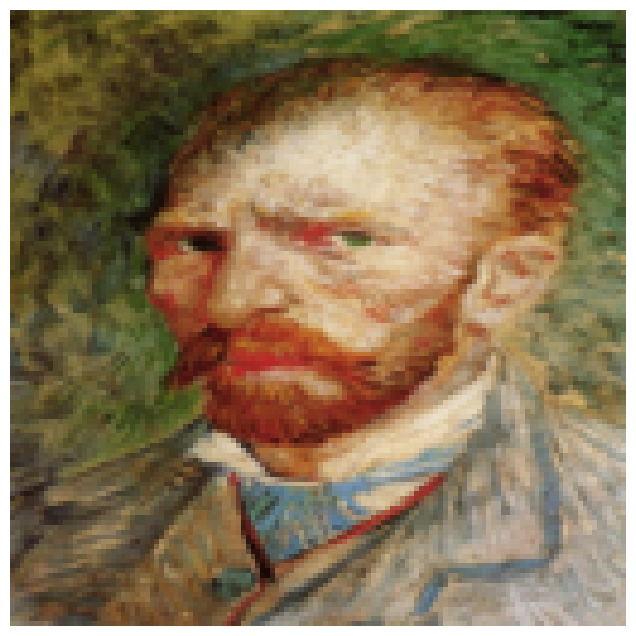

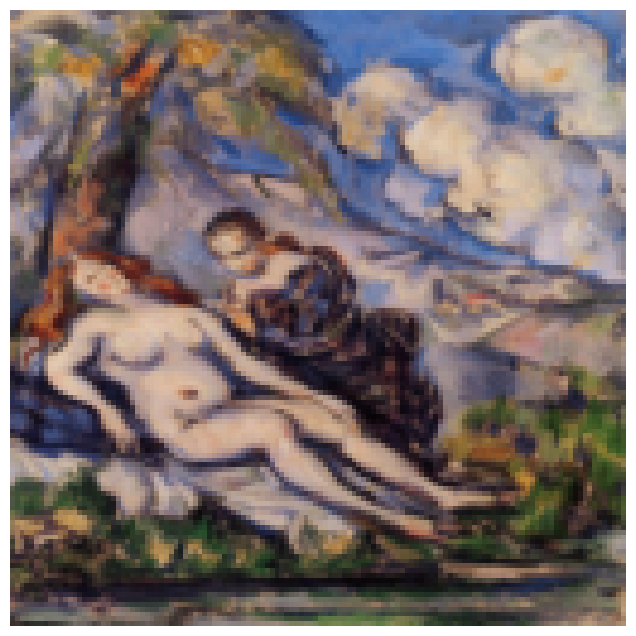

In [25]:
display_tensor_image(van_gogh_paintings['image_tensor'][50])
display_tensor_image(other_paintings['image_tensor'][27])

### **Dataloaders**

In [26]:
class ImageDataFrameDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = row['image_tensor']
        label = torch.tensor(row['label'], dtype=torch.float32)
        return image, label

In [27]:
VGtrain_data, VGtest_data = train_test_split(Van_Gogh_image_data, test_size=0.2, random_state=42, shuffle=True)
VGtraindataset = ImageDataFrameDataset(VGtrain_data)
VGtraindataloader  = DataLoader(VGtraindataset, batch_size=12, shuffle=True)
VGtestdataset = ImageDataFrameDataset(VGtest_data)
VGtestdataloader  = DataLoader(VGtestdataset, batch_size=12, shuffle=True)

### **GAN architecture**

In [28]:
class GAN:
    def __init__(self, generator, discriminator, latent_dim=20, device='cuda'):
        """
        Initialize the GAN with a focus on Van Gogh classification

        Args:
            generator: Pretrained generator model
            discriminator: Pretrained discriminator model
            latent_dim: Dimension of the latent space for generator input
            device: Device to run the models on (cuda or cpu)
        """
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.latent_dim = latent_dim

        self.generator = generator.to(self.device)
        self.discriminator = discriminator.to(self.device)
        # Initialize optimizers as None
        self.optimizer_G = None
        self.optimizer_D = None

        # For tracking metrics
        self.g_losses = []
        self.d_losses = []
        self.van_gogh_acc = []
        self.fake_detection = []

    def _adapt_discriminator(self, discriminator):
        """
        Adapt the discriminator to output Van Gogh/Not Van Gogh classification
        and real/fake classification
        """
        class AdaptedDiscriminator(nn.Module):
            def __init__(self, base_discriminator):
                super().__init__()
                self.base = base_discriminator

                # Get the feature size from the base discriminator
                feature_size = base_discriminator.linear.in_features

                self.van_gogh_head = nn.Linear(feature_size, 1)  # Van Gogh/Not Van Gogh

            def forward(self, x, y = None):
                # Extract features from the input image
                h = x
                for index, blocklist in enumerate(self.base.blocks):
                    for block in blocklist:
                        h = block(h)
                h = torch.sum(self.base.activation(h), [2, 3])
                if y is not None:
                    h = self.base.linear(h)
                    y = y.long()
                    h = h + torch.sum(self.base.embed(y) * h, 1, keepdim=True)
                    h = self.van_gogh_head(h)
                    out = h.mean(dim=0, keepdim=True).squeeze(0)
                else:
                    h = self.van_gogh_head(h)
                    out = h

                return out

        return AdaptedDiscriminator(discriminator).to(self.device)

    def set_optimizers(self, optimizer_G=None, optimizer_D=None):
        if optimizer_G is not None:
            self.optimizer_G = optimizer_G
        if optimizer_D is not None:
            self.optimizer_D = optimizer_D

        # Validate they point at the right params
        self._validate_optimizers()
        print("✅ Attached pretrained optimizers to GAN object.")

    def prune_optimizers(self):
        """
        Remove any frozen (requires_grad=False) parameters from both
        self.optimizer_G and self.optimizer_D, preserving optimizer state
        (momentum, Adam averages) for the rest.
        """
        def _prune(opt):
            # 1) collect IDs of the params we still want
            kept_ids = {
                id(p) for group in opt.param_groups for p in group['params']
                if p.requires_grad
            }
            # 2) prune state dict
            opt.state = {
                p: st for p, st in opt.state.items()
                if id(p) in kept_ids
            }
            # 3) prune param_groups
            new_groups = []
            for group in opt.param_groups:
                new_params = [p for p in group['params'] if p.requires_grad]
                if not new_params:
                    continue
                group['params'] = new_params
                new_groups.append(group)
            opt.param_groups = new_groups

        _prune(self.optimizer_G)
        _prune(self.optimizer_D)
        print("✅ Pruned both optimizers to remove frozen parameters.")

    def to_device(self, *args):
        if len(args) == 1:
            return args[0].to(self.device)
        return [x.to(self.device) for x in args]

    def import_models(self, generator_path, discriminator_path):
        """
        Import pretrained generator and discriminator models from given paths

        Args:
            generator_path: Path to the pretrained generator model
            discriminator_path: Path to the pretrained discriminator model
        """
        self.generator.load_state_dict(torch.load(generator_path, map_location=self.device))
        self.discriminator.load_state_dict(torch.load(discriminator_path, map_location=self.device))
        print("✅ Imported pretrained models into GAN object.")

    def train(self, dataloader,
          optimizer_G=None, optimizer_D=None,
          epochs=50, n_critic=5, sample_interval=500,
          lr_g=0.0002, lr_d=0.0002, betas=(0.5, 0.999)):
        """
        Train the GAN with a focus on Van Gogh classification using mixed precision training

        Args:
            dataloader: DataLoader with real images and Van Gogh labels
                        (expected format: (images, (class_labels, van_gogh_labels)))
            optimizer_G: Pre-configured generator optimizer (optional)
            optimizer_D: Pre-configured discriminator optimizer (optional)
            epochs: Number of training epochs
            n_critic: Number of critic (discriminator) updates per generator update
            sample_interval: Interval for saving sample images
            lr_g: Learning rate for generator (only used if optimizer_G is None)
            lr_d: Learning rate for discriminator (only used if optimizer_D is None)
            betas: Beta parameters for Adam optimizer (only used if optimizers are None)
        """

        # Set the optimizers
        if optimizer_G is not None:
            self.optimizer_G = optimizer_G
        else:
            self.optimizer_G = optim.Adam(self.generator.parameters(), lr=lr_g, betas=betas)

        if optimizer_D is not None:
            self.optimizer_D = optimizer_D
        else:
            self.optimizer_D = optim.Adam(self.discriminator.parameters(), lr=lr_d, betas=betas)

        # Validate optimizers are configured properly
        self._validate_optimizers()

        van_gogh_loss_fn = nn.BCEWithLogitsLoss()

        # Create output directory for samples
        os.makedirs("van_gogh_samples", exist_ok=True)

        self.discriminator = self._adapt_discriminator(self.discriminator)


        # Training loop
        for epoch in range(epochs):
            d_loss_epoch = 0.0
            g_loss_epoch = 0.0
            van_gogh_acc_epoch = 0.0
            batches_processed = 0

            for i, (real_imgs, labels) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):

                van_gogh_labels = labels.long().view(-1, 1).to(self.device)

                batch_size = real_imgs.size(0)

                # Move data to device
                real_imgs = real_imgs.to(self.device)
                vg_labels_float = labels.float().view(-1, 1).to(self.device)
                van_gogh_labels = labels.long().view(-1, 1).to(self.device)

                # ---------------------
                # Train Discriminator
                # ---------------------

                for _ in range(n_critic):
                    self.optimizer_D.zero_grad()

                    y = torch.full((batch_size, 1), fill_value=1, device=self.device, dtype=torch.long)
                    y_emb = self.generator.shared(y)
                    z = torch.randn(batch_size, self.latent_dim, device=self.device)
                    fake_imgs = self.generator(z, y_emb)
                    fake_labels = torch.zeros((batch_size,1), dtype=torch.float, device=self.device)
                    # Get predictions for real images
                    real_vg_pred = self.discriminator(real_imgs, van_gogh_labels)
                    d_real_vg_loss = van_gogh_loss_fn(real_vg_pred, vg_labels_float)

                    fake_vg_pred = self.discriminator(fake_imgs, fake_labels)
                    d_fake_vg_loss = van_gogh_loss_fn(fake_vg_pred, fake_labels)

                        # Total discriminator loss
                    d_loss = d_real_vg_loss + d_fake_vg_loss

                    d_loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), max_norm=1.0)
                    self.optimizer_D.step()


                torch.cuda.empty_cache()
                gc.collect()

                # Track metrics
                d_loss_epoch += d_loss.item()

                # -----------------
                # Train Generator
                # -----------------

                self.optimizer_G.zero_grad()

                # Generate new fake images
                y = torch.full((batch_size, 1), fill_value=1, device=self.device, dtype=torch.long)
                y_emb = self.generator.shared(y)
                z = torch.randn(batch_size, self.latent_dim, device=self.device)
                fake_imgs = self.generator(z, y_emb)

                fake_vg_pred = self.discriminator(fake_imgs)

                one_labels_float = torch.ones((batch_size, 1), device=self.device)
                g_vg_loss = van_gogh_loss_fn(fake_vg_pred, one_labels_float)

                # Total generator loss
                g_loss = g_vg_loss

                g_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.generator.parameters(), max_norm=1.0)
                self.optimizer_G.step()


                g_loss_epoch += g_loss.item()
                batches_processed += 1

                # Print progress
                if i % 50 == 0:
                    print(
                        f"[Epoch {epoch+1}/{epochs}] [Batch {i}/{len(dataloader)}] "
                        f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}] "
                    )


            # Average epoch metrics
            if batches_processed > 0:
                d_loss_epoch /= batches_processed
                g_loss_epoch /= batches_processed
                van_gogh_acc_epoch /= batches_processed

            # Store metrics
            self.d_losses.append(d_loss_epoch)
            self.g_losses.append(g_loss_epoch)
            self.van_gogh_acc.append(van_gogh_acc_epoch)

            # Print epoch summary
            print(
                f"\n[Epoch {epoch+1}/{epochs}] "
                f"[D loss: {d_loss_epoch:.4f}] [G loss: {g_loss_epoch:.4f}] "
            )

            # After using tensors that won't be needed again
            del fake_imgs, fake_vg_pred, real_vg_pred
            torch.cuda.empty_cache()
            gc.collect()

    def freeze_layers(self, layers_to_freeze, model='generator', exact_keys=False):
        """
        Freeze specified layers in either the generator or discriminator.

        Args:
            layers_to_freeze (list of str): Layer names to freeze
            model (str): 'generator' or 'discriminator'
            exact_keys (bool): If True, treat layers_to_freeze as exact parameter keys
                            rather than component names
        """
        # Select the right sub-model
        if model == 'generator':
            m = self.generator
        elif model == 'discriminator':
            # AdaptedDiscriminator wraps your real backbone in .base
            m = getattr(self.discriminator, 'base', self.discriminator)
        else:
            raise ValueError("model must be 'generator' or 'discriminator'")

        frozen_count = 0
        frozen_names = []

        if exact_keys:
            # Freeze by exact parameter keys
            for name, param in m.named_parameters():
                if name in layers_to_freeze:
                    param.requires_grad = False
                    frozen_count += 1
                    frozen_names.append(name)
        else:
            # Original component-based freezing logic
            def _freeze(mod):
                for p in mod.parameters():
                    p.requires_grad = False

            # Map names → attributes on m
            for name in layers_to_freeze:
                if name == 'shared' and hasattr(m, 'shared'):
                    _freeze(m.shared)
                elif name == 'linear' and hasattr(m, 'linear'):
                    _freeze(m.linear)
                elif name.startswith('block'):
                    idx = int(name.replace('block',''))
                    _freeze(m.blocks[idx])
                elif name == 'output_layer' and hasattr(m, 'output_layer'):
                    _freeze(m.output_layer)
                elif name == 'embed' and hasattr(m, 'embed'):
                    _freeze(m.embed)
                else:
                    raise ValueError(f"Unknown layer '{name}' for {model}")

        # Rebuild optimizers so they ignore frozen params
        self.optimizer_G = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.generator.parameters()),
            lr=self.optimizer_G.defaults['lr'],
            betas=self.optimizer_G.defaults['betas']
        )
        self.optimizer_D = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.discriminator.parameters()),
            lr=self.optimizer_D.defaults['lr'],
            betas=self.optimizer_D.defaults['betas']
        )

        if exact_keys:
            print(f"Froze {frozen_count} parameters in the {model}.")
            if frozen_count < 10:  # Only print names if there are a few
                print(f"Frozen parameters: {frozen_names}")
            else:
                print(f"First few frozen parameters: {frozen_names[:5]}...")
        else:
            print(f"Froze layers {layers_to_freeze} in the {model}.")

    def _validate_optimizers(self):
        if self.optimizer_G is None or self.optimizer_D is None:
            raise ValueError("Both optimizers must be set before training")

            # Check that optimizers are pointing to the correct models
        gen_params = set(id(p) for p in self.generator.parameters())
        disc_params = set(id(p) for p in self.discriminator.parameters())

            # Sample check (checking all parameters can be expensive)
        for param_group in self.optimizer_G.param_groups:
            for param in param_group['params'][:5]:  # Check first 5 parameters
                if id(param) not in gen_params:
                    print("Warning: Generator optimizer contains parameters not from the generator model")
                    break

        for param_group in self.optimizer_D.param_groups:
            for param in param_group['params'][:5]:  # Check first 5 parameters
                if id(param) not in disc_params:
                    print("Warning: Discriminator optimizer contains parameters not from the discriminator model")
                    break

    def save_samples(self, epoch, batch_idx, total_steps):
        """
        Generate and save sample images
        """
        # Generate a grid of sample images
        y = torch.full((16, 1), fill_value=1, device=self.device, dtype=torch.long)
        y_emb = self.generator.shared(y)
        z = torch.randn(16, self.latent_dim, device=self.device)
        with torch.no_grad():
            gen_imgs = self.generator(z, y_emb)
            gen_imgs = make_grid(gen_imgs, nrow=4, normalize=True)

        save_image(gen_imgs, f"van_gogh_samples/step_{total_steps}.png")

        # Also save the most recent generated images for quick inspection
        save_image(gen_imgs, "van_gogh_samples/latest.png")

    def save_models(self, path):
        """
        Save the generator and discriminator models
        """
        torch.save(self.generator.state_dict(), f'generator {path}')
        torch.save(self.discriminator.state_dict(), f'discriminator {path}')

        # Also save optimizer states
        torch.save(self.optimizer_G.state_dict(), f'generator opt {path}')
        torch.save(self.optimizer_D.state_dict(), f'discriminator opt {path}')

    def plot_metrics(self):
        """
        Plot training metrics
        """
        plt.figure(figsize=(15, 10))

        # Plot losses
        plt.subplot(2, 2, 1)
        plt.plot(self.g_losses, label='Generator')
        plt.plot(self.d_losses, label='Discriminator')
        plt.title('GAN Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()


        # Plot sample generated images
        plt.subplot(2, 2, 4)
        y = torch.full((16, 1), fill_value=1, device=self.device, dtype=torch.long)
        y_emb = self.generator.shared(y)
        z = torch.randn(16, self.latent_dim, device=self.device)
        with torch.no_grad():
            gen_imgs = self.generator(z, y_emb)
            grid = make_grid(gen_imgs, nrow=2, normalize=True).cpu()
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.title('Generated Van Gogh-style Samples')
        plt.axis('off')

        plt.tight_layout()
        plt.savefig('van_gogh_gan_metrics.png')
        plt.show()

    def generate_images(self, num_images=16, save_path="generated_van_goghs"):
        """
        Generate and save a batch of Van Gogh-style images
        """
        os.makedirs(save_path, exist_ok=True)

        self.generator.eval()
        with torch.no_grad():
            y = torch.randint(0, 1000, (num_images,), device=self.device)
            y_emb = self.generator.shared(y)
            z = torch.randn(num_images, self.latent_dim, device=self.device)
            gen_imgs = self.generator(z, y_emb)

            # Save individual images
            for i, img in enumerate(gen_imgs):
                save_image(img, f"{save_path}/van_gogh_generated_{i+1}.png", normalize=True)

            # Save a grid
            img_grid = make_grid(gen_imgs, nrow=int(np.sqrt(num_images)), normalize=True)
            save_image(img_grid, f"{save_path}/van_gogh_grid.png")

        print(f"Generated {num_images} Van Gogh-style images at {save_path}")

    def evaluate_image(self, image):
        """
        Evaluate a single image to determine if it's a Van Gogh style image
        and if it's real or fake

        Args:
            image: A preprocessed image tensor

        Returns:
            is_real_prob: Probability that the image is real (not generated)
            is_van_gogh_prob: Probability that the image is in Van Gogh style
        """
        self.discriminator.eval()
        with torch.no_grad():
            image = image.unsqueeze(0).to(self.device)  # Add batch dimension
            vg_pred = self.discriminator(image)

            is_van_gogh_prob = torch.sigmoid(vg_pred).item()

        return is_van_gogh_prob

    def classify_dataset(self, dataloader):
        """
        Classify a whole dataset, returning Van Gogh probabilities
        and real/fake probabilities for each image

        Args:
            dataloader: DataLoader with images to classify

        Returns:
            A list of tuples (image_idx, is_real_prob, is_van_gogh_prob)
        """
        self.discriminator.eval()
        results = []

        with torch.no_grad():
            for i, (images, _) in enumerate(tqdm(dataloader, desc="Classifying images")):
                images = images.to(self.device)
                vg_preds= self.discriminator(images)
                vg_probs = torch.sigmoid(vg_preds).cpu().numpy()

                # Store results
                for j in range(len(images)):
                    results.append((i * dataloader.batch_size + j, vg_probs[j][0]))

        return results

    def plot_van_gogh_auc_curve(self, dataloader):
        """
        Plot the ROC curve and calculate the AUC score for the Van Gogh classifier
        using the model's existing classify_dataset method.

        Parameters:
            model: The model with classify_dataset method
            dataloader: DataLoader containing painting images with labels (1 for Van Gogh, 0 for other)

        Returns:
            float: The AUC score
        """
        # Get predictions using the existing helper function
        results = self.classify_dataset(dataloader)

        # Extract image indices, real probabilities, and Van Gogh probabilities
        image_indices = [r[0] for r in results]
        vg_probs = [r[1] for r in results]

        # Extract ground truth labels from dataloader
        all_labels = []
        for _, labels in dataloader:
            all_labels.extend(labels.cpu().numpy())

        # Make sure we have the correct number of labels
        all_labels = all_labels[:len(vg_probs)]

        # Calculate ROC curve and AUC for Van Gogh predictions
        fpr, tpr, thresholds = roc_curve(all_labels, vg_probs)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Van Gogh Painting Classification')
        plt.legend(loc='lower right')
        plt.grid(True, linestyle='--', alpha=0.7)


        plt.tight_layout()
        plt.show()

        print(f"Van Gogh Classifier AUC Score: {roc_auc:.4f}")
        return roc_auc

### **Load and initialize models**

In [45]:
#!git clone https://github.com/huggingface/pytorch-pretrained-BigGAN.git
!cd pytorch-pretrained-BigGAN
!pip install -r full_requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'full_requirements.txt'


In [46]:
model = BigGAN.from_pretrained(biggan-deep-128, cache_dir=None)

AttributeError: module 'BigGAN' has no attribute 'from_pretrained'

In [47]:
generator = BigGAN.generator(resolution=128, n_classes=2, skip_init=True, G_ch=96).to(device)
discriminator = BigGAN.discriminator(resolution=128, n_classes=2, skip_init=True, D_ch=96).to(device)

AttributeError: module 'BigGAN' has no attribute 'generator'

In [34]:
g_layers_to_freeze = load_partial_weights(generator, 'model dicts\G.pth')
d_layers_to_freeze =  load_partial_weights(discriminator, 'model dicts\D.pth')

NameError: name 'generator' is not defined

In [35]:
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999))

NameError: name 'generator' is not defined

In [36]:
VGgan = GAN(generator, discriminator, latent_dim=128, device='cuda')
VGgan.set_optimizers(generator_optimizer, discriminator_optimizer)
VGgan.freeze_layers(g_layers_to_freeze[1:-2], model='generator', exact_keys=True)
VGgan.freeze_layers(d_layers_to_freeze[1:-2], model='discriminator', exact_keys=True)
VGgan.prune_optimizers()

NameError: name 'generator' is not defined

### **Training**

In [ ]:
num_epochs = 10
VGgan.train(VGtraindataloader, epochs=num_epochs, n_critic = 1)

Epoch 1/10:   0%|          | 1/268 [00:00<04:21,  1.02it/s]

[Epoch 1/10] [Batch 0/268] [D loss: 1.1710] [G loss: 0.7683] 


Epoch 1/10:  19%|█▉        | 51/268 [00:33<02:22,  1.53it/s]

[Epoch 1/10] [Batch 50/268] [D loss: 1.1746] [G loss: 0.0010] 


Epoch 1/10:  38%|███▊      | 101/268 [01:07<01:49,  1.52it/s]

[Epoch 1/10] [Batch 100/268] [D loss: 0.9444] [G loss: 0.0011] 


Epoch 1/10:  56%|█████▋    | 151/268 [01:40<01:18,  1.49it/s]

[Epoch 1/10] [Batch 150/268] [D loss: 0.6582] [G loss: 0.0002] 


Epoch 1/10:  75%|███████▌  | 201/268 [02:13<00:44,  1.52it/s]

[Epoch 1/10] [Batch 200/268] [D loss: 0.6559] [G loss: 0.0000] 


Epoch 1/10:  94%|█████████▎| 251/268 [02:46<00:11,  1.48it/s]

[Epoch 1/10] [Batch 250/268] [D loss: 0.6361] [G loss: 0.0000] 


Epoch 1/10: 100%|██████████| 268/268 [02:57<00:00,  1.51it/s]



[Epoch 1/10] [D loss: 0.9034] [G loss: 0.0248] 


Epoch 2/10:   0%|          | 1/268 [00:00<03:09,  1.41it/s]

[Epoch 2/10] [Batch 0/268] [D loss: 0.6292] [G loss: 0.0000] 


Epoch 2/10:  19%|█▉        | 51/268 [00:33<02:22,  1.52it/s]

[Epoch 2/10] [Batch 50/268] [D loss: 0.6761] [G loss: 0.0000] 


Epoch 2/10:  38%|███▊      | 101/268 [01:06<01:49,  1.52it/s]

[Epoch 2/10] [Batch 100/268] [D loss: 0.6764] [G loss: 0.0000] 


Epoch 2/10:  56%|█████▋    | 151/268 [01:39<01:18,  1.49it/s]

[Epoch 2/10] [Batch 150/268] [D loss: 0.6736] [G loss: 0.0000] 


Epoch 2/10:  75%|███████▌  | 201/268 [02:13<00:43,  1.53it/s]

[Epoch 2/10] [Batch 200/268] [D loss: 0.6515] [G loss: 0.0000] 


Epoch 2/10:  94%|█████████▎| 251/268 [02:46<00:11,  1.52it/s]

[Epoch 2/10] [Batch 250/268] [D loss: 0.6183] [G loss: 0.0000] 


Epoch 2/10: 100%|██████████| 268/268 [02:57<00:00,  1.51it/s]



[Epoch 2/10] [D loss: 0.6618] [G loss: 0.0000] 


Epoch 3/10:   0%|          | 1/268 [00:00<02:57,  1.50it/s]

[Epoch 3/10] [Batch 0/268] [D loss: 0.6381] [G loss: 0.0000] 


Epoch 3/10:  19%|█▉        | 51/268 [00:33<02:21,  1.53it/s]

[Epoch 3/10] [Batch 50/268] [D loss: 0.6769] [G loss: 0.0000] 


Epoch 3/10:  38%|███▊      | 101/268 [01:07<01:52,  1.48it/s]

[Epoch 3/10] [Batch 100/268] [D loss: 0.7067] [G loss: 0.0000] 


Epoch 3/10:  56%|█████▋    | 151/268 [01:39<01:16,  1.52it/s]

[Epoch 3/10] [Batch 150/268] [D loss: 0.6288] [G loss: 0.0000] 


Epoch 3/10:  75%|███████▌  | 201/268 [02:12<00:43,  1.53it/s]

[Epoch 3/10] [Batch 200/268] [D loss: 0.6579] [G loss: 0.0000] 


Epoch 3/10:  94%|█████████▎| 251/268 [02:45<00:11,  1.48it/s]

[Epoch 3/10] [Batch 250/268] [D loss: 0.6379] [G loss: 0.0000] 


Epoch 3/10: 100%|██████████| 268/268 [02:56<00:00,  1.52it/s]



[Epoch 3/10] [D loss: 0.6563] [G loss: 0.0000] 


Epoch 4/10:   0%|          | 1/268 [00:00<03:07,  1.42it/s]

[Epoch 4/10] [Batch 0/268] [D loss: 0.6194] [G loss: 0.0000] 


Epoch 4/10:  19%|█▉        | 51/268 [00:33<02:22,  1.53it/s]

[Epoch 4/10] [Batch 50/268] [D loss: 0.6204] [G loss: 0.0000] 


Epoch 4/10:  38%|███▊      | 101/268 [01:06<01:48,  1.54it/s]

[Epoch 4/10] [Batch 100/268] [D loss: 0.6884] [G loss: 0.0000] 


Epoch 4/10:  56%|█████▋    | 151/268 [01:39<01:16,  1.52it/s]

[Epoch 4/10] [Batch 150/268] [D loss: 0.5970] [G loss: 0.0000] 


Epoch 4/10:  75%|███████▌  | 201/268 [02:12<00:44,  1.51it/s]

[Epoch 4/10] [Batch 200/268] [D loss: 0.6457] [G loss: 0.0000] 


Epoch 4/10:  94%|█████████▎| 251/268 [02:45<00:11,  1.45it/s]

[Epoch 4/10] [Batch 250/268] [D loss: 0.6667] [G loss: 0.0000] 


Epoch 4/10: 100%|██████████| 268/268 [02:56<00:00,  1.52it/s]



[Epoch 4/10] [D loss: 0.6530] [G loss: 0.0000] 


Epoch 5/10:   0%|          | 1/268 [00:00<02:56,  1.51it/s]

[Epoch 5/10] [Batch 0/268] [D loss: 0.6525] [G loss: 0.0000] 


Epoch 5/10:  19%|█▉        | 51/268 [00:33<02:22,  1.52it/s]

[Epoch 5/10] [Batch 50/268] [D loss: 0.5862] [G loss: 0.0000] 


Epoch 5/10:  38%|███▊      | 101/268 [01:06<01:54,  1.46it/s]

[Epoch 5/10] [Batch 100/268] [D loss: 0.6435] [G loss: 0.0000] 


Epoch 5/10:  56%|█████▋    | 151/268 [01:39<01:16,  1.53it/s]

[Epoch 5/10] [Batch 150/268] [D loss: 0.6781] [G loss: 0.0000] 


Epoch 5/10:  75%|███████▌  | 201/268 [02:12<00:43,  1.54it/s]

[Epoch 5/10] [Batch 200/268] [D loss: 0.6746] [G loss: 0.0000] 


Epoch 5/10:  94%|█████████▎| 251/268 [02:45<00:11,  1.53it/s]

[Epoch 5/10] [Batch 250/268] [D loss: 0.7162] [G loss: 0.0000] 


Epoch 5/10: 100%|██████████| 268/268 [02:56<00:00,  1.52it/s]



[Epoch 5/10] [D loss: 0.6492] [G loss: 0.0000] 


Epoch 6/10:   0%|          | 1/268 [00:00<03:06,  1.43it/s]

[Epoch 6/10] [Batch 0/268] [D loss: 0.6369] [G loss: 0.0000] 


Epoch 6/10:  19%|█▉        | 51/268 [00:34<02:24,  1.51it/s]

[Epoch 6/10] [Batch 50/268] [D loss: 0.5967] [G loss: 0.0000] 


Epoch 6/10:  38%|███▊      | 101/268 [01:06<01:48,  1.54it/s]

[Epoch 6/10] [Batch 100/268] [D loss: 0.5849] [G loss: 0.0000] 


Epoch 6/10:  56%|█████▋    | 151/268 [01:39<01:16,  1.52it/s]

[Epoch 6/10] [Batch 150/268] [D loss: 0.6693] [G loss: 0.0000] 


Epoch 6/10:  75%|███████▌  | 201/268 [02:12<00:44,  1.51it/s]

[Epoch 6/10] [Batch 200/268] [D loss: 0.6518] [G loss: 0.0000] 


Epoch 6/10:  94%|█████████▎| 251/268 [02:45<00:11,  1.54it/s]

[Epoch 6/10] [Batch 250/268] [D loss: 0.6588] [G loss: 0.0000] 


Epoch 6/10: 100%|██████████| 268/268 [02:56<00:00,  1.52it/s]



[Epoch 6/10] [D loss: 0.6456] [G loss: 0.0000] 


Epoch 7/10:   0%|          | 1/268 [00:00<02:59,  1.49it/s]

[Epoch 7/10] [Batch 0/268] [D loss: 0.6538] [G loss: 0.0000] 


Epoch 7/10:  19%|█▉        | 51/268 [00:33<02:21,  1.53it/s]

[Epoch 7/10] [Batch 50/268] [D loss: 0.6869] [G loss: 0.0000] 


Epoch 7/10:  38%|███▊      | 101/268 [01:06<01:54,  1.46it/s]

[Epoch 7/10] [Batch 100/268] [D loss: 0.6064] [G loss: 0.0000] 


Epoch 7/10:  56%|█████▋    | 151/268 [01:40<01:16,  1.53it/s]

[Epoch 7/10] [Batch 150/268] [D loss: 0.6473] [G loss: 0.0000] 


Epoch 7/10:  75%|███████▌  | 201/268 [02:12<00:43,  1.54it/s]

[Epoch 7/10] [Batch 200/268] [D loss: 0.6405] [G loss: 0.0000] 


Epoch 7/10:  94%|█████████▎| 251/268 [02:45<00:11,  1.53it/s]

[Epoch 7/10] [Batch 250/268] [D loss: 0.6385] [G loss: 0.0000] 


Epoch 7/10: 100%|██████████| 268/268 [02:56<00:00,  1.52it/s]



[Epoch 7/10] [D loss: 0.6423] [G loss: 0.0000] 


Epoch 8/10:   0%|          | 1/268 [00:00<03:04,  1.44it/s]

[Epoch 8/10] [Batch 0/268] [D loss: 0.6346] [G loss: 0.0000] 


Epoch 8/10:  19%|█▉        | 51/268 [00:34<02:21,  1.53it/s]

[Epoch 8/10] [Batch 50/268] [D loss: 0.6845] [G loss: 0.0000] 


Epoch 8/10:  38%|███▊      | 101/268 [01:07<01:48,  1.54it/s]

[Epoch 8/10] [Batch 100/268] [D loss: 0.7418] [G loss: 0.0000] 


Epoch 8/10:  56%|█████▋    | 151/268 [01:39<01:16,  1.53it/s]

[Epoch 8/10] [Batch 150/268] [D loss: 0.5857] [G loss: 0.0000] 


Epoch 8/10:  75%|███████▌  | 201/268 [02:13<00:46,  1.45it/s]

[Epoch 8/10] [Batch 200/268] [D loss: 0.6450] [G loss: 0.0000] 


Epoch 8/10:  94%|█████████▎| 251/268 [02:46<00:11,  1.54it/s]

[Epoch 8/10] [Batch 250/268] [D loss: 0.6063] [G loss: 0.0000] 


Epoch 8/10: 100%|██████████| 268/268 [02:56<00:00,  1.51it/s]



[Epoch 8/10] [D loss: 0.6400] [G loss: 0.0000] 


Epoch 9/10:   0%|          | 1/268 [00:00<02:58,  1.50it/s]

[Epoch 9/10] [Batch 0/268] [D loss: 0.5950] [G loss: 0.0000] 


Epoch 9/10:  19%|█▉        | 51/268 [00:33<02:21,  1.54it/s]

[Epoch 9/10] [Batch 50/268] [D loss: 0.6170] [G loss: 0.0000] 


Epoch 9/10:  38%|███▊      | 101/268 [01:06<01:54,  1.46it/s]

[Epoch 9/10] [Batch 100/268] [D loss: 0.6442] [G loss: 0.0000] 


Epoch 9/10:  56%|█████▋    | 151/268 [01:39<01:17,  1.51it/s]

[Epoch 9/10] [Batch 150/268] [D loss: 0.6265] [G loss: 0.0000] 


Epoch 9/10:  75%|███████▌  | 201/268 [02:12<00:43,  1.53it/s]

[Epoch 9/10] [Batch 200/268] [D loss: 0.6803] [G loss: 0.0000] 


Epoch 9/10:  94%|█████████▎| 251/268 [02:45<00:11,  1.53it/s]

[Epoch 9/10] [Batch 250/268] [D loss: 0.6573] [G loss: 0.0000] 


Epoch 9/10: 100%|██████████| 268/268 [02:55<00:00,  1.52it/s]



[Epoch 9/10] [D loss: 0.6381] [G loss: 0.0000] 


Epoch 10/10:   0%|          | 1/268 [00:00<02:58,  1.49it/s]

[Epoch 10/10] [Batch 0/268] [D loss: 0.6897] [G loss: 0.0000] 


Epoch 10/10:  19%|█▉        | 51/268 [00:34<02:27,  1.47it/s]

[Epoch 10/10] [Batch 50/268] [D loss: 0.6332] [G loss: 0.0000] 


Epoch 10/10:  38%|███▊      | 101/268 [01:07<01:48,  1.54it/s]

[Epoch 10/10] [Batch 100/268] [D loss: 0.6630] [G loss: 0.0000] 


Epoch 10/10:  56%|█████▋    | 151/268 [01:39<01:16,  1.53it/s]

[Epoch 10/10] [Batch 150/268] [D loss: 0.5761] [G loss: 0.0000] 


Epoch 10/10:  75%|███████▌  | 201/268 [02:12<00:45,  1.48it/s]

[Epoch 10/10] [Batch 200/268] [D loss: 0.6999] [G loss: 0.0000] 


Epoch 10/10:  94%|█████████▎| 251/268 [02:46<00:11,  1.53it/s]

[Epoch 10/10] [Batch 250/268] [D loss: 0.6611] [G loss: 0.0000] 


Epoch 10/10: 100%|██████████| 268/268 [02:56<00:00,  1.52it/s]


[Epoch 10/10] [D loss: 0.6360] [G loss: 0.0000] 


### **Evaluation and testing**

In [ ]:
VGgan.save_models('model_1')

In [ ]:
best_generator = VGgan.generator
best_discriminator = VGgan.discriminator
best_GAN = GAN(best_generator, best_discriminator, latent_dim=128, device='cuda')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


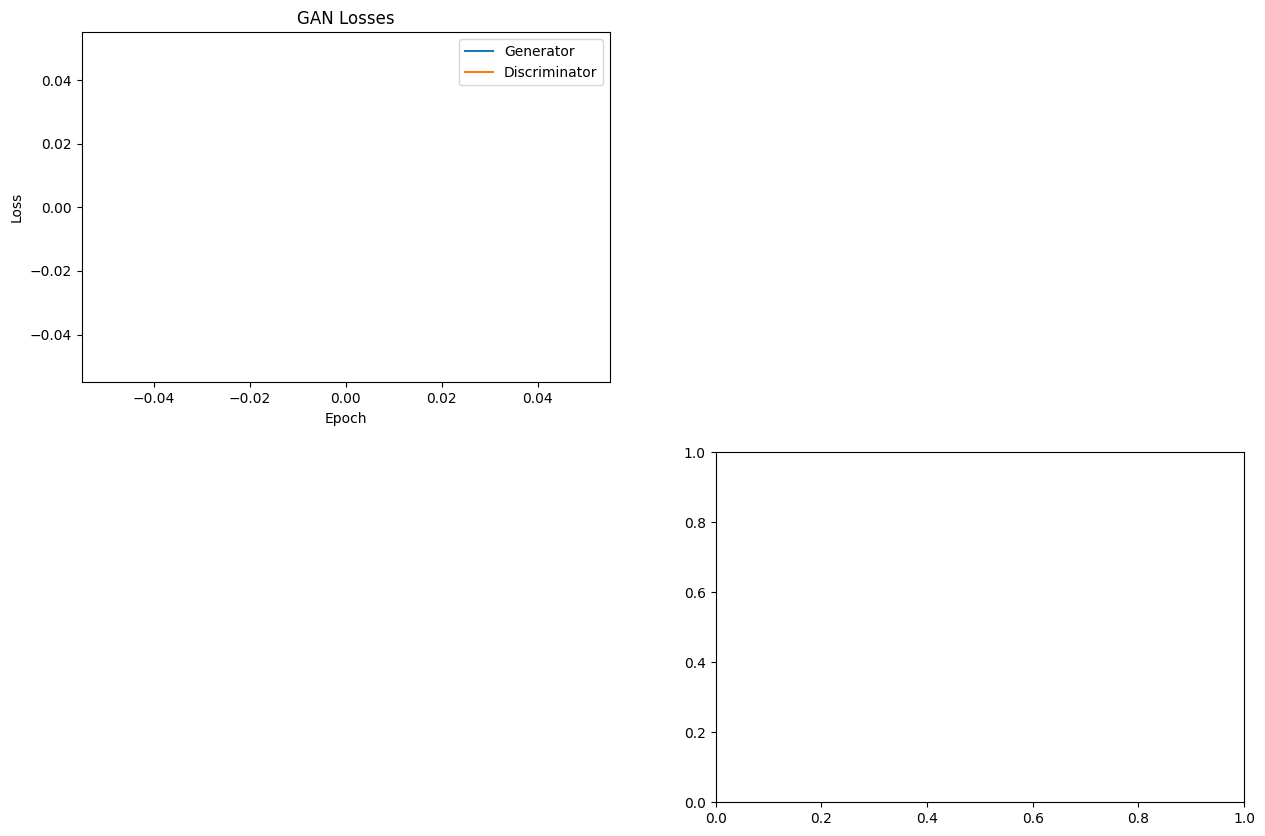

In [ ]:
best_GAN.plot_metrics()

In [ ]:
VGgan.generate_images(num_images=16, save_path="generated_van_goghs_3")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
VGgan.plot_van_gogh_auc_curve(VGtestdataloader)

Classifying images:   0%|          | 0/67 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
